## CSCI 470 Activities and Case Studies

1. For all activities, you are allowed to collaborate with a partner. 
1. For case studies, you should work individually and are **not** allowed to collaborate.

By filling out this notebook and submitting it, you acknowledge that you are aware of the above policies and are agreeing to comply with them.

Some considerations with regard to how these notebooks will be graded:

1. You can add more notebook cells or edit existing notebook cells other than "# YOUR CODE HERE" to test out or debug your code. We actually highly recommend you do so to gain a better understanding of what is happening. However, during grading, **these changes are ignored**. 
2. You must ensure that all your code for the particular task is available in the cells that say "# YOUR CODE HERE"
3. Every cell that says "# YOUR CODE HERE" is followed by a "raise NotImplementedError". You need to remove that line. During grading, if an error occurs then you will not receive points for your work in that section.
4. If your code passes the "assert" statements, then no output will result. If your code fails the "assert" statements, you will get an "AssertionError". Getting an assertion error means you will not receive points for that particular task.
5. If you edit the "assert" statements to make your code pass, they will still fail when they are graded since the "assert" statements will revert to the original. Make sure you don't edit the assert statements.
6. We may sometimes have "hidden" tests for grading. This means that passing the visible "assert" statements is not sufficient. The "assert" statements are there as a guide but you need to make sure you understand what you're required to do and ensure that you are doing it correctly. Passing the visible tests is necessary but not sufficient to get the grade for that cell.
7. When you are asked to define a function, make sure you **don't** use any variables outside of the parameters passed to the function. You can think of the parameters being passed to the function as a hint. Make sure you're using all of those variables.
8. Finally, **make sure you run "Kernel > Restart and Run All"** and pass all the asserts before submitting. If you don't restart the kernel, there may be some code that you ran and deleted that is still being used and that was why your asserts were passing.

# Transfer Learning

We've already looked an example of transfer learning when working with application in Natural Language Processing. For sentiment classification, we used various feature representations including using GloVe representations as the chosen word embedding. That was one example of transfer learning where the approach we used was a feature representation transfer.

In this exercise we will apply transfer learning to computer vision where we will incorporate both parameter transfer as well as feature representation transfer. You can take a look at the available pre-trained models in keras on the [applications page](https://keras.io/applications) in the documentation. In practice, we rarely build a model from scratch and instead use transfer learning to gain the benefit of state of the art models.

For thie exercise, we will use the [CIFAR10 dataset](https://keras.io/datasets/#cifar10-small-image-classification).

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_classes=10

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14847848873617632497,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4930941747
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14171658338042616615
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:22:00.0, compute capability: 6.1"]

In [3]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [4]:
y_train.min(), y_train.max()

(0, 9)

In [5]:
x_test.shape, y_test.shape

((10000, 32, 32, 3), (10000, 1))

In [6]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

y_train.shape, y_test.shape, y_train.min(), y_train.max()

((50000, 10), (10000, 10), 0.0, 1.0)

First, we will use a VGG-16 model to extract features from a sample. The VGG-16 model without the fully connected layers is equivalent to just the pretrained convolutional layers. By passing data through the model we are able to extract features based on the knowledge from the pretrained imagenet dataset.

In [7]:
# Load a VGG16 model with imagenet weights, without the fully connected layers, and with the adjusted input shape for our data
# Save the model as vgg_model
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))


In [8]:
assert vgg_model

In [9]:
example = x_train[10]
example.shape

(32, 32, 3)

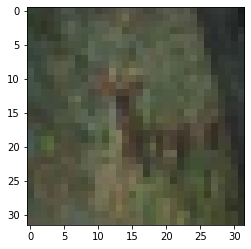

In [10]:
plt.imshow(example)
plt.show()

In [11]:
# Use the vgg_model you loaded to extract the features for the example image
# save the output to example_vgg

example_vgg = vgg_model.predict(np.expand_dims(example, axis=0))

In [12]:
assert np.squeeze(example_vgg).shape == (512,)

Now let's create our own fully connected layers and add those after the `vgg_model`. We can then predict train our model on the CIFAR10 dataset and predict its classes. In the following code, you'll want to use Keras' [functional API](https://www.tensorflow.org/guide/keras/functional) that we've used before. 



In [13]:
# Flatten the Convolutional layers' output then
# Add 3 Dense layers with 256 units each followed by the output layer
# Use the functional API to do this
# Save the final output from the layers as `predictions`

x = vgg_model.output
x = Flatten(data_format=None)(x)
x = Dense(256, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(10, activation="softmax")(x)



vgg_complete = Model(vgg_model.input, predictions)
print(len(vgg_complete.layers) - len(vgg_model.layers))

5


In [14]:
assert len(vgg_complete.layers) - len(vgg_model.layers) == 5
assert vgg_complete.layers[-2].units == 256
assert vgg_complete.layers[-3].units == 256
assert vgg_complete.layers[-4].units == 256

In [15]:
vgg_complete.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [16]:
# Keep the feature extraction weights as is from the trained ImageNet
# This will reduce the time it takes to train the model
# Try setting the value to True instead and run the next cell to look at the difference in ETA.
for layer in vgg_model.layers:
    layer.trainable=False

In [17]:
# This cell will take a while. Double check your work before continuing
vgg_complete.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])
vgg_complete.fit(x_train, y_train, epochs=1, batch_size=128)

Train on 50000 samples
50000/50000 [==============================] - 12s 248us/sample - loss: 1.6108 - accuracy: 0.4968


In [18]:
# Report the accuracy on the test set
# Save it as acc

loss,acc = vgg_complete.evaluate(x_test,y_test, batch_size=128)
print(acc)

10000/10000 [==============================] - 3s 251us/sample - loss: 1.2925 - accuracy: 0.5642
0.5642


In [19]:
assert acc > 0.3

In [20]:
print(f"If you were to guess just one class all the time, your accuracy would be 0.1. Your model accuracy is {acc:.3f}")

If you were to guess just one class all the time, your accuracy would be 0.1. Your model accuracy is 0.564


## Feedback

In [21]:
def feedback():
    """Provide feedback on the contents of this exercise
    
    Returns:
        string
    """
    return "More instruction on formatting data into the correct shape would be useful."
feedback()

'More instruction on formatting data into the correct shape would be useful.'